In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pandas as pd
from src.utils import get_generations, get_metrics, get_all, _process_evalharness_results, get_superglue_results, get_empirical_cdf, print_random_examples, plot_superglue_task, get_auc, _get_params_llama, get_good_models, get_watermark_overrides

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
good_models = pd.read_csv('good_watermarked_models.csv')

# Helper Functions

In [5]:
def get_params(dir):
    model_path = os.path.join(dir, 'models')
    param_path = os.path.join(model_path, os.listdir(model_path)[-1], 'params.json')
    with open(param_path) as f:
        config = json.load(f)


    model_name = config['tokenizer_name']
    param_names = config['watermark_param_names'][0]
    variance = config['variance']
    if 'rank_to_drop' in config.keys():
        rank_to_drop = config['rank_to_drop']
    else:
        rank_to_drop = 0

    if '_ran_' in dir:

        found = re.search(r'_ran_(\d+)', dir)
        if found:
            rank_to_drop = int(found.group(1))


    key = (param_names, variance, rank_to_drop)
    
    return key, model_name

def get_generations(parent):
    """
    Given a path to the parent directory of saved amulet generations, returns a dictionary of generations, where the key is the model parameters and the value is the generations list
    """
    generations = {}

    for dirname in os.listdir(parent):
        dir = os.path.join(parent, dirname)
        try:
            key, model_name = get_params(dir)
            if model_name not in generations.keys():
                generations[model_name] = {}
            with open(os.path.join(dir, 'generations.json')) as f:
                generations[model_name][key] = json.load(f)

        except Exception as e:
            print(e)
            print(f"Error processing {dir}")
        # gen_path = os.path.join(parent, dirname, 'generations.json')
        # if os.path.exists(gen_path):
        #     with open(gen_path) as f:
        #         generations[key] = json.load(f)
        # else:
        #     print(f"No generations found for {key}")

    return generations


def get_metrics(parent,  key_is_path=False):
    """
    Returns eval harness metrics for all experiments in a directory
    """
    metrics = {}
    for dirname in os.listdir(parent):
        try:
            dir = os.path.join(parent, dirname)
            key, model_name = get_params(dir)
            metrics_path = os.path.join(parent, dirname, 'data/eval_results/results.json')
            with open(metrics_path) as f:
                results = json.load(f)
            
            if model_name not in metrics.keys():
                metrics[model_name] = {}
            
            metrics[model_name][key] = _process_evalharness_results(results)
            if key_is_path:
                metrics[model_name][key]['path'] = dir
        except Exception as e:

            print(f"Error processing {dir}: {e}")
    return metrics



def get_layer_mlp_type(param_name):
    splits = param_name.split('.')
    return splits[2], splits[4]

def is_match(param_info, param):
    
    keys = set(param_info.keys())
    param_names, variance, rank_to_drop = param
    layer, mlp_type = get_layer_mlp_type(param_names)

    param_data ={
        'layer': int(layer),
        'mlp_type': mlp_type,
        'rank': rank_to_drop,
        'variance': variance
    }
    matches = True
    for key in keys:
        if param_info[key] != param_data[key]:
            matches = False
            break
    return matches





In [6]:
def get_path_to_uncorrupted(watermark_override, laserized, good_models, parent='/home/blockadam/gaussian-watermarking/amlt'):
    """
    Given a watermark override, returns the path to the model
    """
    row = good_models[good_models['watermark_overrides'] == watermark_override]
    row = row[row['laserized'] == laserized]
    if row.shape[0] == 0:
        raise ValueError(f"Could not find model with watermark override {watermark_override} and laserized {laserized}")

    exp_name = row['exp_name'].values[0]
    run_name = row['run_name'].values[0]
    return os.path.join(parent, exp_name, run_name)

def get_watermark_overrides(path):
    with open(os.path.join(path, 'config.json'), 'r') as f:
        config = json.load(f)
    return config['model']['watermark_overrides']

def get_corruption_type(path):
    with open(os.path.join(path, 'config.json'), 'r') as f:
        config = json.load(f)
    
    corruption_type = config['corruption_robust']['corruptions'][0]['alias']
    
    # print(config['corruption_robust']['corruptions'][0])
    if corruption_type == 'roundtrip_translation':
        num_corrupted_tokens = None
    else:
        num_corrupted_tokens = float(config['corruption_robust']['corruptions'][0]['token_frac'])
        location = config['corruption_robust']['corruptions'][0]['kwargs']['location']
        temps = corruption_type.split('_')
        corruption_type = '_'.join([temps[0], location, temps[2]])
    
    return corruption_type, num_corrupted_tokens


def _get_corruptions(parent, good_models):
    """
    Returns corruption metrics for all experiments in a directory
    """
    if 'laser' in parent:
        laserized = True
    else:
        laserized = False
    
    generations = {}
    for run_name in os.listdir(parent):

        path = os.path.join(parent, run_name)
        try:
            watermark_overrides = get_watermark_overrides(path)
            key = (watermark_overrides, laserized)
            if key not in generations.keys():
                generations[key] = {}
                path_to_uncorrupted = get_path_to_uncorrupted(watermark_overrides, laserized, good_models)
                with open(os.path.join(path_to_uncorrupted, 'generations.json'), 'r') as f:
                    generations[key]['uncorrupted'] = json.load(f)
            
            
            with open(os.path.join(path, 'generations.json'), 'r') as f:
                gens = json.load(f)

            corruption_type, num_corrupted_tokens = get_corruption_type(path)
            if corruption_type == 'roundtrip_translation':
                generations[key][corruption_type] = gens
            elif corruption_type not in generations[key].keys():
                generations[key][corruption_type] = {
                    num_corrupted_tokens: gens
                }
            else:
                generations[key][corruption_type][num_corrupted_tokens] = gens
        except Exception as e:
            print(f"Error processing {path}: {e}")
            
    return generations

        
def recursively_update_dict(old_dict, updates):
    for key in updates.keys():
        if key in old_dict.keys():
            if isinstance(old_dict[key], dict):
                recursively_update_dict(old_dict[key], updates[key])
            else:
                old_dict[key] = updates[key]
        else:
            old_dict[key] = updates[key]

def get_corruptions(parents, good_models):

    generations = {}
    for parent in parents:
        recursively_update_dict(generations, _get_corruptions(parent, good_models))
    
    return generations

def get_corruptions_numpassed(data_dict, sig_pval=0.05):

    num_passed, num_corrupted = [], []
    data = {key: data_dict[key] for key in sorted(data_dict.keys())}
    for key, data in data.items():
        num_passed.append(data[data['pvalue'] < sig_pval].shape[0] / data.shape[0])
        num_corrupted.append(key)

    return num_corrupted, num_passed

def get_corruptions_auc(data_dict, grid_size=500):
    
        aucs, num_corrupted = [], []
        data = {key: data_dict[key] for key in sorted(data_dict.keys())}
        for key, data in data.items():
            grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)
            auc = get_auc(grid, cdf)
            aucs.append(auc)
            num_corrupted.append(key)
    
        return num_corrupted, aucs


# Getting Data

In [7]:
parents = [
    # '09-19-corrupt-phi',
    # '09-19-corrupt-mistral',
    # '09-19-roundtrip-translation',
    # '09-19-roundtrip-translation-laser',
    '09-19-corrupt-llama',
    '09-19-roundtrip-translation-llama',
    # '09-19-roundtrip-translation-llama-laser',
    '09-23-corrupt-mistral'

]
parents = [os.path.join('./amlt', parent) for parent in parents]

generations = get_corruptions(parents, good_models)

print('\n\n')
print('Models:')
for key in generations.keys():
    print(key)

Error processing ./amlt/09-23-corrupt-mistral/grid_09-23-corrupt-mistral_cor_add_start_tokens_tok_0.01_wat_mistralai_Mistral-7B-v0.3_____64_____30___up_proj___weight_____1e-05: [Errno 2] No such file or directory: './amlt/09-23-corrupt-mistral/grid_09-23-corrupt-mistral_cor_add_start_tokens_tok_0.01_wat_mistralai_Mistral-7B-v0.3_____64_____30___up_proj___weight_____1e-05/config.json'



Models:
('meta-llama/Meta-Llama-3.1-8B@___@0@___@29@@@down_proj@@@weight@___@3e-05', False)
('meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@down_proj@@@weight@___@3e-05', False)
('mistralai/Mistral-7B-v0.3@___@64@___@30@@@up_proj@@@weight@___@1e-05', False)
('mistralai/Mistral-7B-v0.3@___@0@___@31@@@gate_proj@@@weight@___@3e-06', False)


In [9]:
laserized = False
# watermark_override = 'microsoft/Phi-3-mini-4k-instruct@___@0@___@28@@@gate_up_proj@@@weight@___@0.001'
# watermark_override = 'microsoft/Phi-3-mini-4k-instruct@___@0@___@28@@@down_proj@@@weight@___@0.001'
# watermark_override = 'mistralai/Mistral-7B-v0.3@___@32@___@31@@@gate_proj@@@weight@___@3e-05'
# watermark_override = 'mistralai/Mistral-7B-v0.3@___@128@___@31@@@gate_proj@@@weight@___@3e-05'

# watermark_override = 'mistralai/Mistral-7B-v0.3@___@64@___@30@@@up_proj@@@weight@___@1e-05'
# watermark_override = 'mistralai/Mistral-7B-v0.3@___@0@___@31@@@gate_proj@@@weight@___@3e-06'

watermark_override = 'meta-llama/Meta-Llama-3.1-8B@___@0@___@29@@@down_proj@@@weight@___@3e-05'
watermark_override = 'meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@down_proj@@@weight@___@3e-05'


# lazerized = True
# watermark_override = 'microsoft/Phi-3-mini-4k-instruct@___@64@___@31@@@gate_up_proj@@@weight@___@0.001'
# watermark_override = 'microsoft/Phi-3-mini-4k-instruct@___@128@___@31@@@down_proj@@@weight@___@0.0001'
# watermark_override = 'mistralai/Mistral-7B-v0.3@___@32@___@31@@@gate_proj@@@weight@___@3e-05'
# watermark_override = 'mistralai/Mistral-7B-v0.3@___@128@___@31@@@gate_proj@@@weight@___@3e-05'
# watermark_override = 'meta-llama/Meta-Llama-3.1-8B@___@32@___@31@@@gate_proj@@@weight@___@0.0001'
# watermark_override = 'meta-llama/Meta-Llama-3.1-8B@___@128@___@31@@@gate_proj@@@weight@___@0.0001'




wat_params = (watermark_override, laserized)


# corruption_type = 'substitute_start_tokens'
# corruption_type = 'add_random_tokens'
# corruption_type = 'substitute_random_tokens'
# corruption_type = 'remove_start_tokens'
# corruption_type = 'remove_random_tokens'
corruption_type = 'add_start_tokens'

min_prob = 1e-20
data_param = {key: get_all(value, min_prob) for key, value in generations[wat_params][corruption_type].items()}

data_param[0.0] = get_all(generations[wat_params]['uncorrupted'], min_prob)




# Summary statistics

In [10]:
sig_pval = 0.05

num_passed = {}

for key, data in data_param.items():

    num_passed[key] = data[data['pvalue'] < sig_pval].shape[0] / data.shape[0]


print(f"Watermark Parmeters: {wat_params}")
print(f"Corruption Type: {corruption_type}")
print(f"Significance threshold: {sig_pval:.4f}")


num_passed = {key: num_passed[key] for key in sorted(num_passed.keys())}
for key in num_passed.keys():
    print(f"Fraction significant generations {key} corrupted tokens: {num_passed[key]:.4f}")
print('\n')

Watermark Parmeters: ('meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@down_proj@@@weight@___@3e-05', False)
Corruption Type: add_start_tokens
Significance threshold: 0.0500
Fraction significant generations 0.0 corrupted tokens: 0.7320
Fraction significant generations 0.01 corrupted tokens: 0.6867
Fraction significant generations 0.1 corrupted tokens: 0.5155
Fraction significant generations 0.2 corrupted tokens: 0.3924
Fraction significant generations 0.5 corrupted tokens: 0.1291




## Num passed

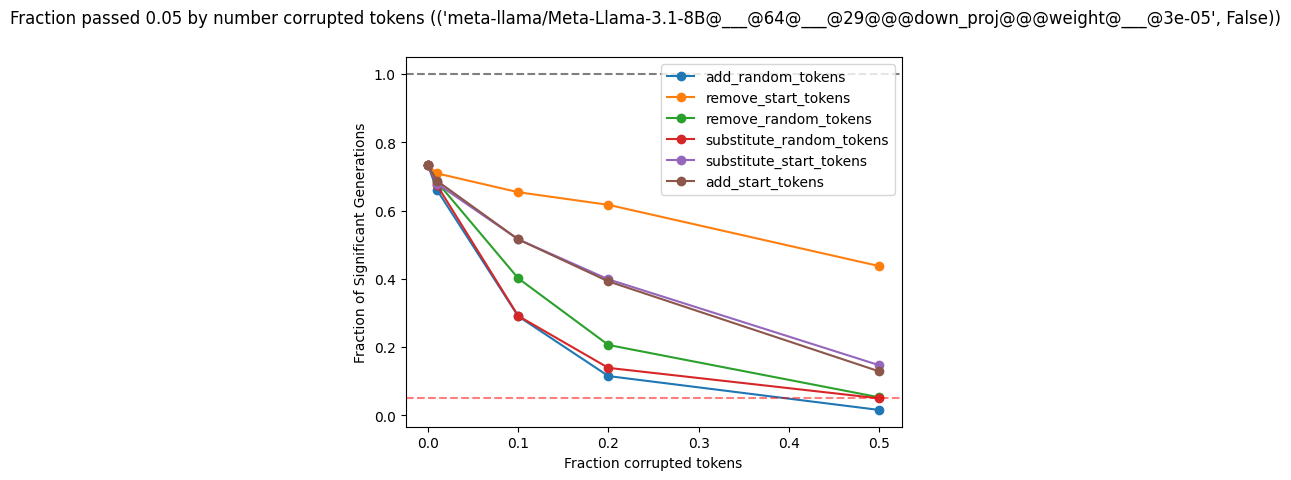

In [11]:
sig_pval = 0.05


min_prob = 1e-20
all_param_data = {}
for corruption_type in generations[wat_params].keys():
    if corruption_type != 'uncorrupted' and corruption_type != 'roundtrip_translation':
        all_param_data[corruption_type] = {key: get_all(value, min_prob) for key, value in generations[wat_params][corruption_type].items()}
        all_param_data[corruption_type][0.0] = get_all(generations[wat_params]['uncorrupted'], min_prob)



fig, ax = plt.subplots()
for corruption_type, data_dict in all_param_data.items():
    num_corrupted, num_passed = get_corruptions_numpassed(data_dict, sig_pval=sig_pval)
    ax.plot(num_corrupted, num_passed, label=f'{corruption_type}', marker='o')

ax.legend()
ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.axhline(sig_pval, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Fraction corrupted tokens')
ax.set_ylabel('Fraction of Significant Generations')
fig.suptitle(f"Fraction passed {sig_pval} by number corrupted tokens ({wat_params})")

plt.show()

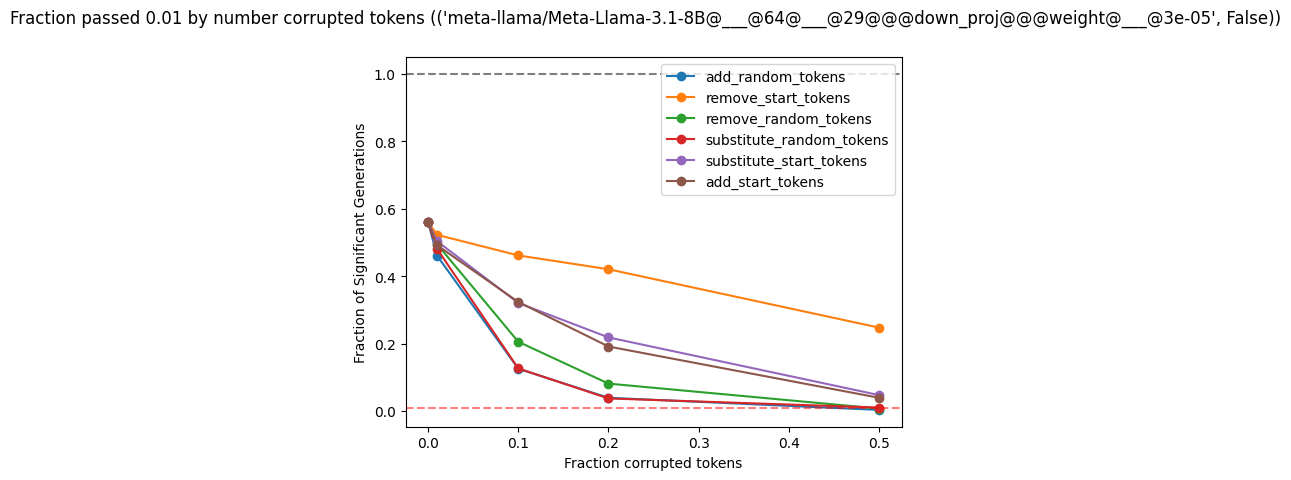

In [12]:
sig_pval = 0.01
fig, ax = plt.subplots()
for corruption_type, data_dict in all_param_data.items():
    num_corrupted, num_passed = get_corruptions_numpassed(data_dict, sig_pval=sig_pval)
    ax.plot(num_corrupted, num_passed, label=f'{corruption_type}', marker='o')

ax.legend()
ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.axhline(sig_pval, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Fraction corrupted tokens')
ax.set_ylabel('Fraction of Significant Generations')
fig.suptitle(f"Fraction passed {sig_pval} by number corrupted tokens ({wat_params})")

plt.show()

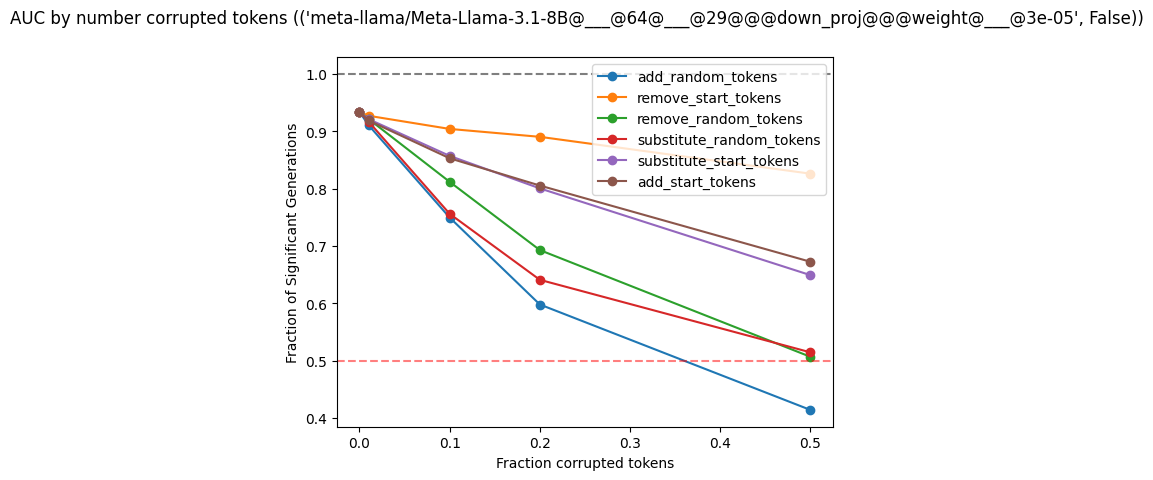

In [13]:
fig, ax = plt.subplots()
for corruption_type, data_dict in all_param_data.items():
    num_corrupted, aucs = get_corruptions_auc(data_dict)
    ax.plot(num_corrupted, aucs, label=f'{corruption_type}', marker='o')

ax.legend()
ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Fraction corrupted tokens')
ax.set_ylabel('Fraction of Significant Generations')
fig.suptitle(f"AUC by number corrupted tokens ({wat_params})")

plt.show()

## ROC curves

AUC 0.0: 0.9338
AUC 0.01: 0.9188
AUC 0.1: 0.8529
AUC 0.2: 0.8054
AUC 0.5: 0.6725


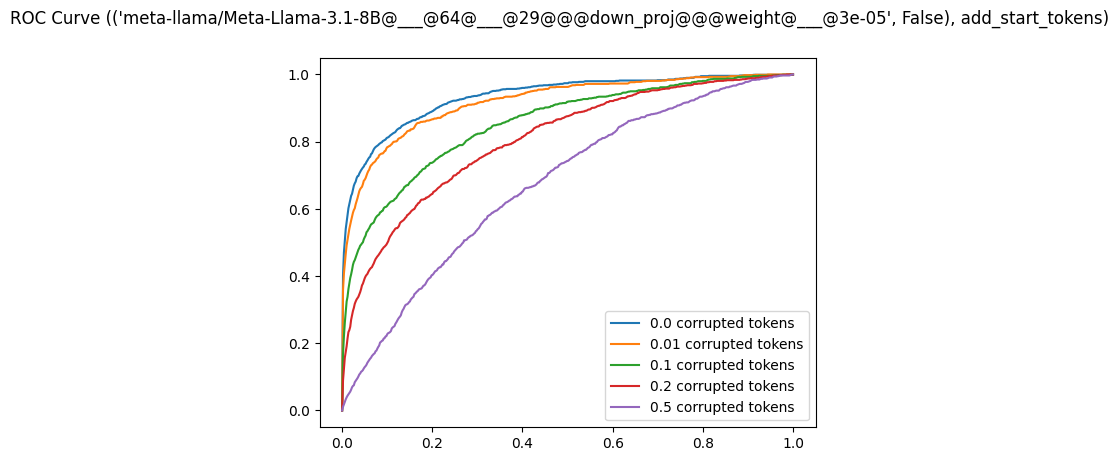

In [14]:
grid_size = 500
fig, ax = plt.subplots()
data_param = {key: data_param[key] for key in sorted(data_param.keys())}
for key, data in data_param.items():
    grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)
    auc = get_auc(grid, cdf)
    print(f"AUC {key}: {auc:.4f}")
    ax.plot(grid, cdf, label=f'{key} corrupted tokens')

ax.legend()
fig.suptitle(f'ROC Curve ({wat_params}, {corruption_type})')
plt.show()

# Roundtrip Translation

In [15]:
roundtrip_translation_data = {}
for param, value in generations.items():
    if 'roundtrip_translation' in value.keys():
        roundtrip_translation_data[param] = get_all(value['roundtrip_translation'], min_prob)



Significance threshold:  0.05
('meta-llama/Meta-Llama-3.1-8B@___@0@___@29@@@down_proj@@@weight@___@3e-05', False): AUC 0.6097, Fraction significant generations: 0.0910
('meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@down_proj@@@weight@___@3e-05', False): AUC 0.6005, Fraction significant generations: 0.0780


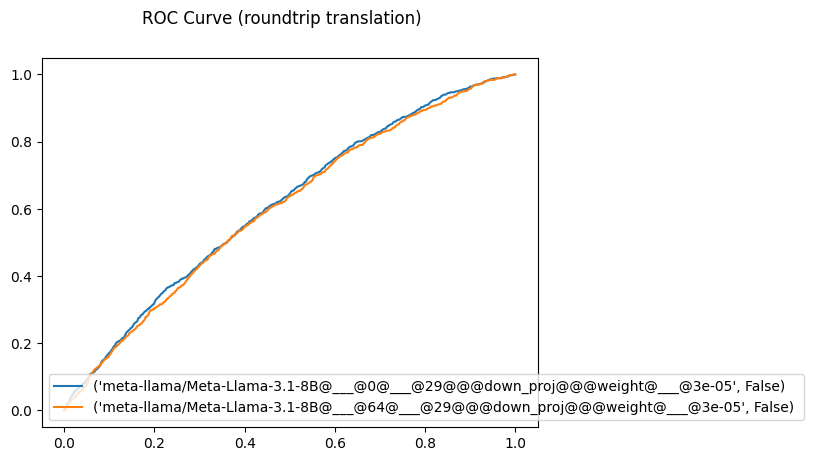

In [18]:
sig_pval = 0.05

grid_size = 500
fig, ax = plt.subplots()
print("Significance threshold: ", sig_pval)
for key, data in roundtrip_translation_data.items():
    grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)
    num_passed = data[data['pvalue'] < sig_pval].shape[0] / data.shape[0]
    auc = get_auc(grid, cdf)
    print(f"{key}: AUC {auc:.4f}, Fraction significant generations: {num_passed:.4f}")
    ax.plot(grid, cdf, label=f'{key} ')

ax.legend()
fig.suptitle(f'ROC Curve (roundtrip translation)')
plt.show()

# Number of tokens ablation

In [17]:
def _get_numtokens_generations(parent):
    """
    Given a path to the parent directory of saved amulet generations, returns a dictionary of generations, where the key is the model parameters and the value is the generations list
    """
    generations = {}
    data = {}
    for dirname in os.listdir(parent):
        dir = os.path.join(parent, dirname)
        found = re.search('_max_(\d+)', dir)
        num_tokens = int(found.group(1))
        try:
            key, model_name = get_params(dir)
            if model_name not in generations.keys():
                generations[model_name] = {}
                data[model_name] = {}
            
            if key not in generations[model_name].keys():
                generations[model_name][key] = {}
                data[model_name][key] = {}

            with open(os.path.join(dir, 'generations.json')) as f:

                generations[model_name][key][num_tokens] = json.load(f)
            
            data[model_name][key][num_tokens] = get_all(generations[model_name][key][num_tokens], 1e-20)

        except Exception as e:
            print(e)
            print(f"Error processing {dir}")
        # gen_path = os.path.join(parent, dirname, 'generations.json')
        # if os.path.exists(gen_path):
        #     with open(gen_path) as f:
        #         generations[key] = json.load(f)
        # else:
        #     print(f"No generations found for {key}")

    return generations, data

def get_num_tokens_generations(parents):

    generations = {}
    data = {}
    for parent in parents:
        gens, datum = _get_numtokens_generations(parent)
        recursively_update_dict(generations, gens)
        recursively_update_dict(data, datum)

    return generations, data


def get_numtokens_numpassed(data_dict, sig_pval=0.05):

    num_passed, num_tokens = [], []
    data = {key: data_dict[key] for key in sorted(data_dict.keys())}
    for key, data in data.items():
        num_passed.append(data[data['pvalue'] < sig_pval].shape[0] / data.shape[0])
        num_tokens.append(key)

    return num_tokens, num_passed

def get_numtokens_auc(data_dict, grid_size=500):
    
        aucs, num_tokens = [], []
        data = {key: data_dict[key] for key in sorted(data_dict.keys())}
        for key, data in data.items():
            grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)
            auc = get_auc(grid, cdf)
            aucs.append(auc)
            num_tokens.append(key)
    
        return num_tokens, aucs


In [16]:
num_tokens_parents = [
    # './amlt/09-19-watermark-numtokens.yaml',
    # './amlt/09-22-watermark-numtokens-llama',
    './amlt/09-19-watermark-numtokens-laser',
    './amlt/09-22-watermark-numtokens-llama-laser',
    './amlt/09-23-watemark-numtokens-mistral'
]

num_tokens_generations, num_tokens_data = get_num_tokens_generations(num_tokens_parents)



[Errno 2] No such file or directory: './amlt/09-19-watermark-numtokens-laser/grid_09-19-watermark-numtokens-laser_max_20_wat_microsoft_Phi-3-mini-4k-instruct_____128_____31___down_proj___weight_____0.0001/generations.json'
Error processing ./amlt/09-19-watermark-numtokens-laser/grid_09-19-watermark-numtokens-laser_max_20_wat_microsoft_Phi-3-mini-4k-instruct_____128_____31___down_proj___weight_____0.0001
[Errno 2] No such file or directory: './amlt/09-19-watermark-numtokens-laser/grid_09-19-watermark-numtokens-laser_max_500_wat_microsoft_Phi-3-mini-4k-instruct_____64_____31___gate_up_proj___weight_____0.001/generations.json'
Error processing ./amlt/09-19-watermark-numtokens-laser/grid_09-19-watermark-numtokens-laser_max_500_wat_microsoft_Phi-3-mini-4k-instruct_____64_____31___gate_up_proj___weight_____0.001


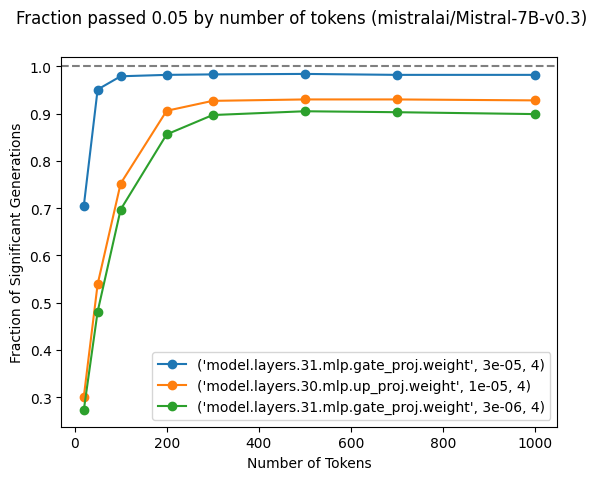

In [17]:
# model = 'microsoft/Phi-3-mini-4k-instruct'
model = 'mistralai/Mistral-7B-v0.3'
# model = 'meta-llama/Meta-Llama-3.1-8B'
sig_pval = 0.05

fig, ax = plt.subplots()
for param, data_dict in num_tokens_data[model].items():
    num_tokens, num_passed = get_numtokens_numpassed(data_dict)
    ax.plot(num_tokens, num_passed, label=f'{param}', marker='o')

ax.legend()
ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Fraction of Significant Generations')
fig.suptitle(f"Fraction passed {sig_pval} by number of tokens ({model})")

plt.show()

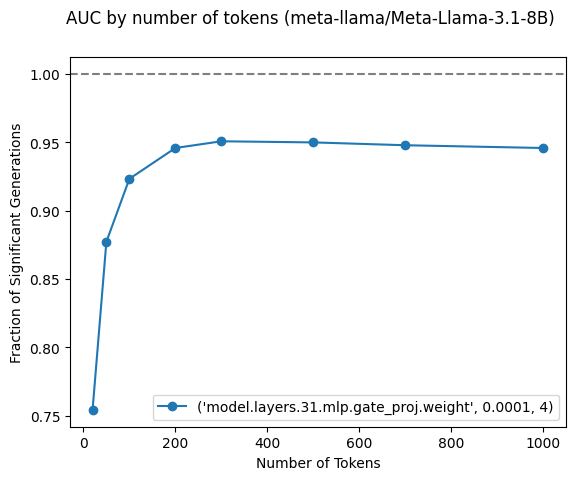

In [53]:
fig, ax = plt.subplots()
grid_size = 500
for param, data_dict in num_tokens_data[model].items():
    num_tokens, aucs = get_numtokens_auc(data_dict, grid_size=grid_size)
    ax.plot(num_tokens, aucs, label=f'{param}', marker='o')


ax.legend()
ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Fraction of Significant Generations')
fig.suptitle(f"AUC by number of tokens ({model})")

plt.show()